In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

##### Data Downloaded From https://www.kaggle.com/mirichoi0218/insurance
### Inspect Data The Data for Linearity

In [2]:
df = pd.read_csv('./insurance.csv')
#Replace 'Smoker' column yes/no data with 1 and 0
a = df['smoker'].copy()
k = pd.get_dummies(a, drop_first = True)
df['smoker'] = k
#Print data for inspection.
print(df.head())
df.describe().transpose()

   age     sex     bmi  children  smoker     region      charges
0   19  female  27.900         0       1  southwest  16884.92400
1   18    male  33.770         1       0  southeast   1725.55230
2   28    male  33.000         3       0  southeast   4449.46200
3   33    male  22.705         0       0  northwest  21984.47061
4   32    male  28.880         0       0  northwest   3866.85520


,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
smoker,1338.0,0.204783,0.403694,0.0000,0.00000,0.000,0.000000,1.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


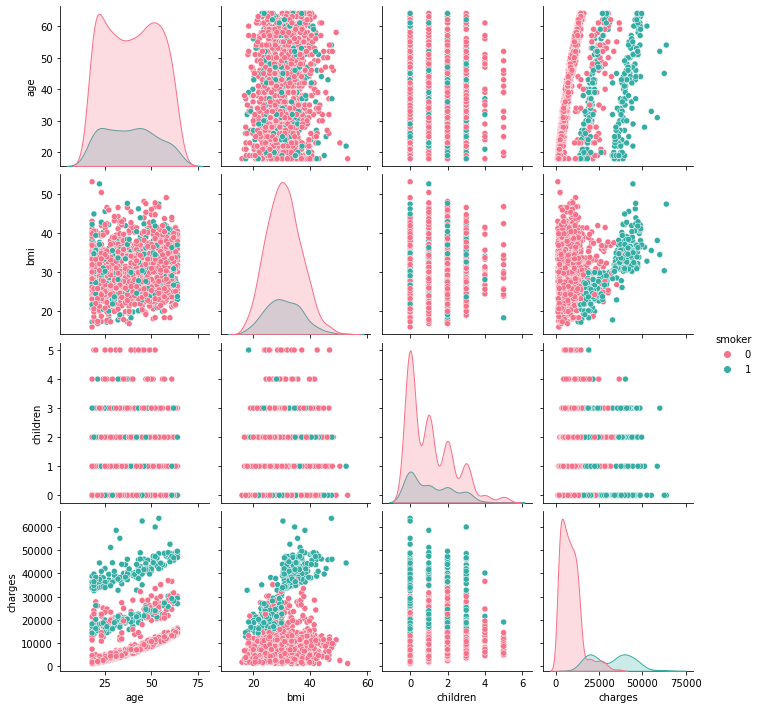

In [3]:
#Pairwise visualization
sb.pairplot(df[['age', 'bmi', 'children', 'charges', 'smoker']], hue='smoker', palette=sb.color_palette("husl", 2), diag_kind='kde');

In [4]:
#Copy the data that has potential to influence model
dftrain = df[['age', 'bmi', 'children', 'charges', 'smoker']].copy()
#Remove target data for training
y_train = dftrain.pop('charges')

### Define Linear Regression Model Based on Notes

In [5]:
class LinearModel:
    def __init__(self, num_parameters, lr = 0.1):
        self.learning_rate = lr
        self.thetas = np.random.uniform(-1, 1, num_parameters + 1)

    def standardize_X(self,arr):
        means = []
        varis = []
        cols = []
        for i in range(len(arr[0])):
            mean = sum(arr[:, i])/len(arr[:, i])
            vari = np.var(arr[:, i])
            col = (np.array(arr[:,i] - mean) / np.sqrt(vari))
            means.append(mean)
            varis.append(vari)   
            cols.append(col)
            
        self.means = means
        self.varis = varis
        
        return np.array(cols).transpose()
    
    def standardize_Y(self, arr):
        mean = sum(arr)/len(arr)
        vari = np.var(arr)
        
        self.mean_Y = mean
        self.vari_Y = vari
        
        return (arr - mean) / np.sqrt(vari)
        
    
    def train(self, X, Y):
        X = np.insert(X, 0, 1)
        L = [self.thetas[v[0]] * v[1] for v in enumerate(X)]
        h_x = sum(L)
        self.thetas = [a[1] - self.learning_rate*(h_x - Y)*X[a[0]] for a in enumerate(self.thetas)]
    
    def predict(self, X):
        X = (X - self.means) / np.sqrt(self.varis)
        X = np.insert(X, 0, 1)
        L = [self.thetas[v[0]] * v[1] for v in enumerate(X)]
        h_x = sum(L)
        out = (h_x * np.sqrt(self.vari_Y)) + self.mean_Y 
        return out
        
        

### Define a new linear model with 4 fit parameters. Standardize the training data and outputs and train on standardized data.

In [6]:
A = LinearModel(4)

st_train = A.standardize_X(np.array(dftrain))
y_st = A.standardize_Y(np.array(y_train))

for i,j in enumerate(st_train):
    A.train(j, y_st[i])


### Test trained model on the data and calculate error as difference between prediction and true value for all test data then plot as histogram

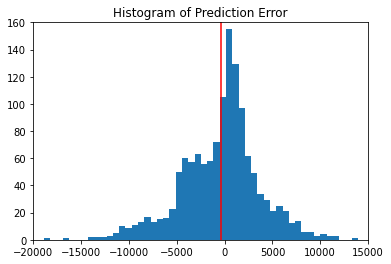

In [14]:
errorlist = []
for i in range(len(np.array(dftrain))):
    errorlist.append((A.predict(np.array(dftrain.iloc[i])) - y_train[i]) / 2)
    
errorlist = np.array(errorlist)
mean = sum(errorlist)/len(errorlist)
var = errorlist.var()
sigma = np.sqrt(var)

plt.hist(errorlist, bins=50);
plt.vlines(mean, 0, 160, 'r')
plt.axis([-20000, 15000, 0, 160])
plt.title('Histogram of Prediction Error');

### Isolate the patients that are smokers and plot bmi vs charges observing strong linear trend to test linear fit with one parameter.

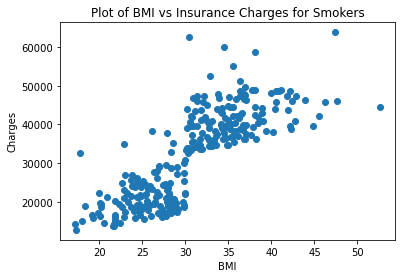

In [15]:
plottable = df[['smoker','bmi', 'charges']].copy()
plottable = plottable.loc[plottable['smoker'] == 1]
y_plots = plottable.pop('charges')
plottable.pop('smoker')

plt.plot(plottable['bmi'], y_plots, 'o')
plt.title("Plot of BMI vs Insurance Charges for Smokers")
plt.xlabel('BMI')
plt.ylabel('Charges');

### Train the one parameter model on the bmi data

In [9]:
B = LinearModel(1)

st_train = B.standardize_X(np.array(plottable))
y_st = B.standardize_Y(np.array(y_plots))

for i,j in enumerate(st_train):
    B.train(j, y_st[i])

### Plot the line predicted by the linear model over the data to obeserve an appropriate linear fit

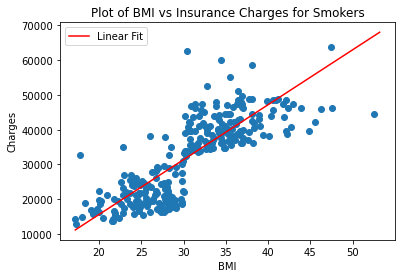

In [16]:
xs = np.arange(plottable['bmi'].min(), plottable['bmi'].max()+1)
ys = [B.predict(np.array([i])) for i in xs]
plt.plot(plottable['bmi'], y_plots, 'o')
plt.plot(xs, ys, 'r', label='Linear Fit')
plt.title("Plot of BMI vs Insurance Charges for Smokers")
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend();